In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms


import matplotlib.pyplot as plt
import time
import copy
import os

In [2]:
data_dir = "data/image_data"

model_name = "resnet34"

num_classes = 2

batch_size = 8


num_epochs = 15

feature_extract = True

In [3]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=5):
    tik = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                  
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                        _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                # calculating losses for plotting and statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)#(pred == labels).sum().item()
                                
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()
    tok = time.time()
    time_taken = tok - tik
    print('Training complete in {:.0f}m {:.0f}s'.format(time_taken // 60, time_taken % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

This helper function sets the .requires_grad attribute of the parameters in the model to False when we are feature extracting. By default, when we load a pretrained model all of the parameters have .requires_grad=True, which is fine if we are training from scratch or finetuning. However, if we are feature extracting and only want to compute gradients for the newly initialized layer then we want all of the other parameters to not require gradients. This will make more sense later.

In [4]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [5]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224
    
    elif model_name == "resnet34":
        """ Resnet34
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract= True, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /home/balahari/.torch/models/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:02<00:00, 23410053.96it/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

model.classifier[6] = nn.Linear(4096,num_classes)


In [6]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders...


In [7]:
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 fc.weight
	 fc.bias


In [8]:
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

Epoch 0/14
----------
train Loss: 0.5796 Acc: 0.6598
val Loss: 0.3186 Acc: 0.8889

Epoch 1/14
----------
train Loss: 0.3573 Acc: 0.8525
val Loss: 0.4048 Acc: 0.8170

Epoch 2/14
----------
train Loss: 0.4794 Acc: 0.7746
val Loss: 0.2725 Acc: 0.8954

Epoch 3/14
----------
train Loss: 0.3194 Acc: 0.8811
val Loss: 0.2011 Acc: 0.9412

Epoch 4/14
----------
train Loss: 0.2964 Acc: 0.8566
val Loss: 0.1815 Acc: 0.9412

Epoch 5/14
----------
train Loss: 0.3232 Acc: 0.8320
val Loss: 0.2673 Acc: 0.9020

Epoch 6/14
----------
train Loss: 0.2595 Acc: 0.9016
val Loss: 0.2229 Acc: 0.9281

Epoch 7/14
----------
train Loss: 0.3359 Acc: 0.8402
val Loss: 0.1841 Acc: 0.9477

Epoch 8/14
----------
train Loss: 0.4068 Acc: 0.7869
val Loss: 0.2067 Acc: 0.9281

Epoch 9/14
----------
train Loss: 0.2936 Acc: 0.8689
val Loss: 0.1810 Acc: 0.9412

Epoch 10/14
----------
train Loss: 0.2552 Acc: 0.8934
val Loss: 0.1869 Acc: 0.9412

Epoch 11/14
----------
train Loss: 0.2095 Acc: 0.9221
val Loss: 0.1831 Acc: 0.9477

Ep

Epoch 0/14
----------
train Loss: 0.7293 Acc: 0.4918
val Loss: 0.7506 Acc: 0.5425

Epoch 1/14
----------
train Loss: 0.6820 Acc: 0.5943
val Loss: 0.6191 Acc: 0.6405

Epoch 2/14
----------
train Loss: 0.6372 Acc: 0.6557
val Loss: 0.7024 Acc: 0.6078

Epoch 3/14
----------
train Loss: 0.6385 Acc: 0.6311
val Loss: 0.6218 Acc: 0.7320

Epoch 4/14
----------
train Loss: 0.6358 Acc: 0.6598
val Loss: 0.5661 Acc: 0.6863

Epoch 5/14
----------
train Loss: 0.6438 Acc: 0.6189
val Loss: 0.6522 Acc: 0.6144

Epoch 6/14
----------
train Loss: 0.6271 Acc: 0.6516
val Loss: 0.6620 Acc: 0.6601

Epoch 7/14
----------
train Loss: 0.6862 Acc: 0.6311
val Loss: 0.7222 Acc: 0.6275

Epoch 8/14
----------
train Loss: 0.6346 Acc: 0.6516
val Loss: 0.5659 Acc: 0.6863

Epoch 9/14
----------
train Loss: 0.6289 Acc: 0.6311
val Loss: 0.6717 Acc: 0.6928

Epoch 10/14
----------
train Loss: 0.5839 Acc: 0.6680
val Loss: 0.7140 Acc: 0.6078

Epoch 11/14
----------
train Loss: 0.6728 Acc: 0.6148
val Loss: 0.6025 Acc: 0.6732

Ep

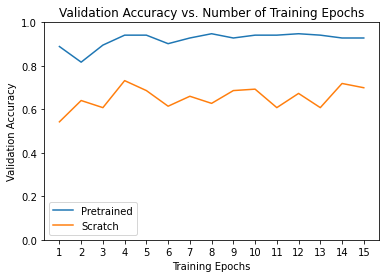

In [9]:
# Initialize the non-pretrained version of the model used for this run
scratch_model,_ = initialize_model(model_name, num_classes, feature_extract=False, use_pretrained=False)
scratch_model = scratch_model.to(device)
scratch_optimizer = optim.SGD(scratch_model.parameters(), lr=0.001, momentum=0.9)
scratch_criterion = nn.CrossEntropyLoss()
_,scratch_hist = train_model(scratch_model, dataloaders_dict, scratch_criterion, scratch_optimizer, num_epochs=num_epochs)

# Plot the training curves of validation accuracy vs. number
#  of training epochs for the transfer learning method and
#  the model trained from scratch
ohist = []
shist = []

ohist = [h.cpu().numpy() for h in hist]
shist = [h.cpu().numpy() for h in scratch_hist]

plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),ohist,label="Pretrained")
plt.plot(range(1,num_epochs+1),shist,label="Scratch")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

In [10]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
# Saving the model
model_dir = 'saved_models/'
model_name = 'res_net_custom.pt'


torch.save(scratch_model.state_dict(), model_dir+model_name)